In [1]:
import jax.numpy as jnp
import numpy as np
from jax import grad
import matplotlib.pyplot as plt

datapath = "./"

In [2]:
def show_dataset(x, y):
    y = y.flatten()
    num_classes = np.size(np.unique(y.flatten()))
    accessible_color_cycle = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
    # initialize figure
    plt.figure()

    # color current class
    for a in range(0, num_classes):
        t = np.argwhere(y == a)
        t = t[:, 0]
        plt.scatter(
          x[0, t],
          x[1, t],
          s=50,
          color=accessible_color_cycle[a],
          edgecolor='k',
          linewidth=1.5,
          label="class:" + str(a))
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.legend(bbox_to_anchor=(1.1, 1.05))

    # plt.savefig("data.png")
    plt.show()

In [3]:
data = np.loadtxt(datapath + '4class_data.csv', delimiter=',')


In [4]:
x = data[:-1, :]
y = data[-1:, :]

In [5]:
print(np.shape(x))
print(np.shape(y))

(2, 40)
(1, 40)


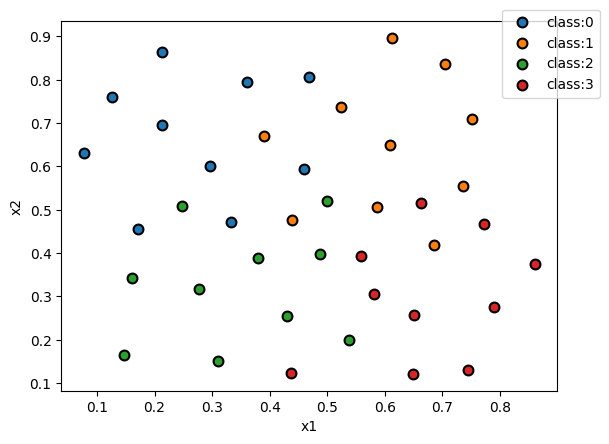

In [6]:
show_dataset(x, y)

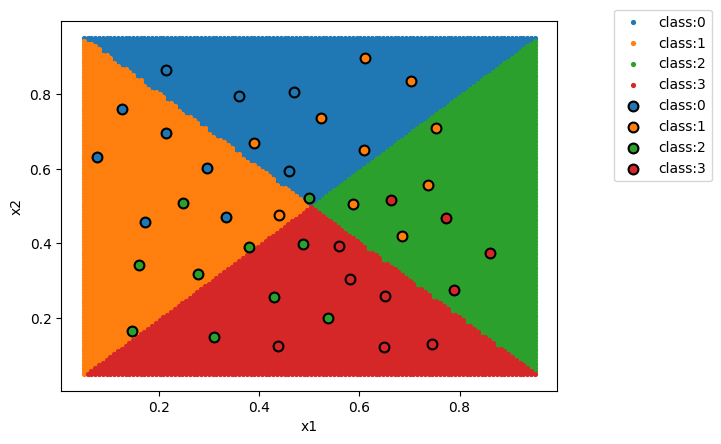

In [7]:
def show_dataset_labels(x, y, modelf, n_axis_pts=120):
    y = y.flatten()
    num_classes = np.size(np.unique(y.flatten()))
    accessible_color_cycle = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
    # initialize figure
    plt.figure()

    # fill in label regions using scatter points
    # get (x1, x2) for plot region
    anyax = np.linspace(0.05, 0.95, num=n_axis_pts)
    xx = np.meshgrid(anyax, anyax)
    xx_vars = np.reshape(xx, (2, n_axis_pts ** 2))
    # get class weights from classifier model
    z = modelf(xx_vars)
    # get class label from model output
    y_hat = z.argmax(axis=1)

    for a in range(0, num_classes):
        t = np.argwhere(y_hat == a)
        t = t[:, 0]
        plt.scatter(
            xx_vars[0, t],
            xx_vars[1, t],
            s=5,
            color=accessible_color_cycle[a],
            linewidth=1.5,
            label="class:" + str(a))

    # color current class
    for a in range(0, num_classes):
        t = np.argwhere(y == a)
        t = t[:, 0]
        plt.scatter(
            x[0, t],
            x[1, t],
            s=50,
            color=accessible_color_cycle[a],
            edgecolor='k',
            linewidth=1.5,
            label="class:" + str(a))
        plt.xlabel("x1")
        plt.ylabel("x2")
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    # plt.savefig("classifier_label_regions.png")
    plt.show()
    
def dummy_classifier_model(xs):
    y_hats = np.zeros((np.shape(xs)[1], 4))
    ys = ((1 - xs[0, :]) > xs[1, :]).astype(int)
    ys[np.where(xs[0, :] > xs[1, :])] = ys[np.where(xs[0, :] > xs[1, :])] + 2
    for i, e in enumerate(ys):
        y_hats[i, e] = 1
    return y_hats

show_dataset_labels(x, y, dummy_classifier_model)

# Task3: multiclass softmax

In [8]:
def gradient_descent_adam(cost_func, x, y, alpha=1e-2, iterations=500):
	"""
	:param w_initial:
	:param cost_func:
	:param x: a array of N_features*N_samples; rows are each feature; each column is a sample
	:param y: a array of the same size of N_samples
	:param alpha:
	:param iterations:
	:return:
	"""
	gradient = grad(cost_func, argnums=0)

	# w = np.array([3.,3.])
	w_dim = (3, 4)
	w = np.random.rand(w_dim[0], w_dim[1])
	cost = cost_func(w, x, y)
	w_history = [w, ]
	cost_history = [cost, ]
	alpha_initial = np.empty(0)
	alpha_initial.fill(alpha)  # learning rate for w0 and w1
	beta = 0.9
	beta_2 = 0.999
	epsilon = 1e-8
	grad_history = [gradient(w, x, y), ]
	momentum_history = [np.zeros(w_dim), ]
	secondary_list = [np.zeros(w_dim), ]

	for i in np.arange(1, iterations, 1):
		# get gradient
		w_grad = gradient(w, x, y)
		grad_history.append(w_grad)

		# get momentum
		momentum = (1 - beta) * w_grad + beta * momentum_history[-1]
		momentum_history.append(momentum)

		# second derivative estimate
		w_grad_square = w_grad ** 2
		secondary = beta_2 * secondary_list[-1] + (1 - beta_2) * w_grad_square
		secondary_list.append(secondary)

		# momentum with normalization <-- adam
		w = w - ((alpha * momentum / (1 - jnp.power(beta, i))) / (
					jnp.sqrt(secondary / (1 - jnp.power(beta_2, i))) + epsilon))
		w_history.append(w)

		# cost
		cost = cost_func(w, x, y)
		cost_history.append(cost)

	return w_history, cost_history

In [9]:
def multiclass_softmax_cost(w, x, y, lamb=1e-2):
    # x_append_transpose = jnp.vstack([jnp.ones(len(x.shape)), x.flatten()]).T
    # tmp = -y.flatten()*jnp.dot(x_append_transpose, w)

    x_append_transpose = jnp.vstack([jnp.ones(x.shape[1]), x]).T

    # there are in total four classes
    # w0, w1, w2, w3 <-- weights to learn;
    # <-- w: dimension 3*4

    tmp = jnp.sum(jnp.exp(jnp.dot(x_append_transpose, w)), axis=1)
    w_yp_idx = y.astype('int').flatten()
    tmp_w_yp = jnp.sum(x_append_transpose*w[:, w_yp_idx].T, axis=1)

    # feature touching weights
    w_touch_feature = w[1:, :]
    cost = jnp.sum(jnp.log(tmp - tmp_w_yp)) / y.flatten().size + lamb * jnp.sum(w_touch_feature**2)
    return cost

In [10]:
w_dim = (3, 4)
w = np.random.rand(w_dim[0], w_dim[1])
w

array([[0.49214218, 0.7736219 , 0.18258194, 0.05270343],
       [0.06045065, 0.94322254, 0.91263211, 0.65311386],
       [0.5891389 , 0.3948113 , 0.16670001, 0.33379129]])

In [13]:
x_append_transpose = jnp.vstack([jnp.ones(x.shape[1]), x]).T
print(x_append_transpose.shape)
x_append_transpose

(40, 3)


DeviceArray([[1.      , 0.12558 , 0.75948 ],
             [1.      , 0.077189, 0.6312  ],
             [1.      , 0.17166 , 0.45627 ],
             [1.      , 0.29608 , 0.60204 ],
             [1.      , 0.3606  , 0.79446 ],
             [1.      , 0.21313 , 0.86443 ],
             [1.      , 0.45968 , 0.59329 ],
             [1.      , 0.33295 , 0.47085 ],
             [1.      , 0.46889 , 0.80612 ],
             [1.      , 0.21313 , 0.69534 ],
             [1.      , 0.39055 , 0.6691  ],
             [1.      , 0.52419 , 0.73615 ],
             [1.      , 0.43894 , 0.47668 ],
             [1.      , 0.58641 , 0.50583 ],
             [1.      , 0.60945 , 0.64869 ],
             [1.      , 0.70392 , 0.83528 ],
             [1.      , 0.73618 , 0.55539 ],
             [1.      , 0.7523  , 0.70991 ],
             [1.      , 0.68548 , 0.41837 ],
             [1.      , 0.61175 , 0.8965  ],
             [1.      , 0.2477  , 0.50875 ],
             [1.      , 0.49885 , 0.52041 ],
          

In [16]:
jnp.exp(jnp.dot(x_append_transpose, w))

DeviceArray([[2.5784097, 3.2934084, 1.5277493, 1.4743679],
             [2.383745 , 2.9910762, 1.4308206, 1.3686237],
             [2.162631 , 3.0516305, 1.514832 , 1.3731617],
             [2.3743544, 3.6349068, 1.7387285, 1.563666 ],
             [2.6697583, 4.1678896, 1.9042983, 1.7391562],
             [2.75742  , 3.728245 , 1.6840334, 1.616787 ],
             [2.385623 , 4.226778 , 2.0157716, 1.7349209],
             [2.2026591, 3.5735686, 1.7593307, 1.5331483],
             [2.705816 , 4.637405 , 2.106202 , 1.8738925],
             [2.4959712, 3.4874785, 1.6372277, 1.5280616],
             [2.4841835, 4.0802803, 1.9165934, 1.7008307],
             [2.6052392, 4.7525916, 2.1895385, 1.89796  ],
             [2.2244444, 3.958395 , 1.9398978, 1.6462382],
             [2.2832394, 4.6017857, 2.2301757, 1.8304055],
             [2.487187 , 4.9757648, 2.332457 , 1.948911 ],
             [2.7920904, 5.8553343, 2.6228018, 2.206158 ],
             [2.3722682, 5.404748 , 2.5780337, 2.0521686

In [69]:
tmp = jnp.log(jnp.sum(jnp.exp(jnp.dot(x_append_transpose, w)), axis=1))
print(tmp.shape)
tmp

(40,)


DeviceArray([2.1831183, 2.100991 , 2.0921423, 2.2312667, 2.3495739,
             2.2810025, 2.3382509, 2.2048297, 2.426864 , 2.2136161,
             2.3206105, 2.4375818, 2.2792115, 2.3929381, 2.4633698,
             2.6009388, 2.5182786, 2.5879002, 2.4305468, 2.5598404,
             2.1626947, 2.3373003, 2.2045996, 2.107801 , 2.0399473,
             1.9614232, 2.065821 , 2.1883101, 2.2826283, 2.2434433,
             2.1435304, 2.4501219, 2.5123205, 2.4529736, 2.3459098,
             2.330466 , 2.3138652, 2.2934666, 2.3672965, 2.5420551],            dtype=float32)

In [68]:
jnp.log(jnp.sum(jnp.exp(all_evals), axis=0))

DeviceArray([2.1831183, 2.1009908, 2.0921423, 2.231267 , 2.3495739,
             2.2810025, 2.3382509, 2.2048297, 2.426864 , 2.2136161,
             2.3206105, 2.4375818, 2.2792115, 2.3929381, 2.4633696,
             2.6009388, 2.5182786, 2.5879002, 2.4305468, 2.5598404,
             2.1626947, 2.3373003, 2.2045996, 2.107801 , 2.0399475,
             1.9614232, 2.065821 , 2.1883101, 2.2826283, 2.2434433,
             2.1435304, 2.4501219, 2.5123203, 2.4529736, 2.3459098,
             2.3304658, 2.3138652, 2.2934666, 2.3672965, 2.5420551],            dtype=float32)

In [18]:
w_yp_idx = y.astype('int').flatten()
print(w_yp_idx.shape)
w_yp_idx

(40,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [23]:
w

array([[0.49214218, 0.7736219 , 0.18258194, 0.05270343],
       [0.06045065, 0.94322254, 0.91263211, 0.65311386],
       [0.5891389 , 0.3948113 , 0.16670001, 0.33379129]])

In [ ]:
w[:, w_yp_idx].T

array([[0.49214218, 0.06045065, 0.5891389 ],
       [0.49214218, 0.06045065, 0.5891389 ],
       [0.49214218, 0.06045065, 0.5891389 ],
       [0.49214218, 0.06045065, 0.5891389 ],
       [0.49214218, 0.06045065, 0.5891389 ],
       [0.49214218, 0.06045065, 0.5891389 ],
       [0.49214218, 0.06045065, 0.5891389 ],
       [0.49214218, 0.06045065, 0.5891389 ],
       [0.49214218, 0.06045065, 0.5891389 ],
       [0.49214218, 0.06045065, 0.5891389 ],
       [0.7736219 , 0.94322254, 0.3948113 ],
       [0.7736219 , 0.94322254, 0.3948113 ],
       [0.7736219 , 0.94322254, 0.3948113 ],
       [0.7736219 , 0.94322254, 0.3948113 ],
       [0.7736219 , 0.94322254, 0.3948113 ],
       [0.7736219 , 0.94322254, 0.3948113 ],
       [0.7736219 , 0.94322254, 0.3948113 ],
       [0.7736219 , 0.94322254, 0.3948113 ],
       [0.7736219 , 0.94322254, 0.3948113 ],
       [0.7736219 , 0.94322254, 0.3948113 ],
       [0.18258194, 0.91263211, 0.16670001],
       [0.18258194, 0.91263211, 0.16670001],
       [0.

In [29]:
tmp_w_yp = jnp.sum(x_append_transpose*w[:, w_yp_idx].T, axis=1)
tmp_w_yp

DeviceArray([0.94717276, 0.8686728 , 0.7713255 , 0.8647256 , 0.98198795,
             1.0142955 , 0.86946034, 0.7896653 , 0.9954035 , 0.91467786,
             1.4061657 , 1.5586901 , 1.3758388 , 1.5264444 , 1.604579  ,
             1.767353  , 1.6872778 , 1.7634888 , 1.5853593 , 1.7045867 ,
             0.4934495 , 0.7246008 , 0.5933782 , 0.48870647, 0.38583726,
             0.34356797, 0.49044573, 0.61728334, 0.69367486, 0.7068879 ,
             0.37923914, 0.6571145 , 0.7137775 , 0.6600841 , 0.5639531 ,
             0.5485269 , 0.53437793, 0.51671153, 0.582834  , 0.7398248 ],            dtype=float32)

In [ ]:
w_history, cost_history = gradient_descent_adam(multiclass_softmax_cost, x, y, alpha=1e-1, iterations=200)

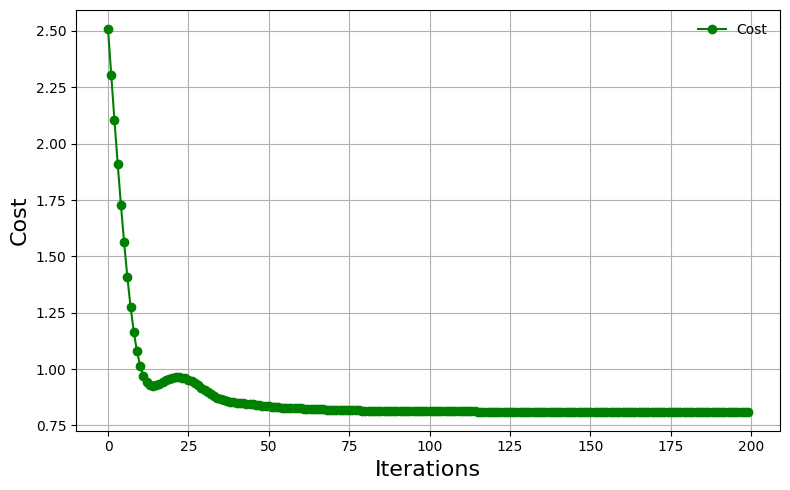

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(cost_history, "go-", label="Cost")
ax.set_xlabel("Iterations", fontsize=16)
ax.set_ylabel("Cost", fontsize=16)
plt.grid()
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("task3-cost.png")
plt.show()

In [78]:
print("final learnt wegihts: ", w_history[-1])

final learnt wegihts:  [[-1.3442405  -2.1115992  -0.81456685 -1.4082576 ]
 [-0.9618676   0.62803435 -0.60236365  0.94296134]
 [ 0.852313    0.75312763 -0.7370048  -0.87472457]]


# Determine the accuracy of my final learnt model

In [79]:
# the learnt weights should always maxize the point in the correct catagory
x_append_transpose = jnp.vstack([jnp.ones(x.shape[1]), x]).T
pred_values = jnp.dot(x_append_transpose, w_history[-1])
pred_y = pred_values.argmax(axis=1)
print(pred_y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 3 1 3 1 0 0 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3
 3 3 3]


In [80]:
# miss-classified
misscalssfications = jnp.count_nonzero(pred_values.argmax(axis=1) - y)
print("misscalssfications", misscalssfications)

misscalssfications 11


In [81]:
acc = (y.size - misscalssfications) / y.size
print("accuracy: ", acc)

accuracy:  0.725


In [82]:
print("accuracy: %.3f %%" % (acc*100))

accuracy: 72.500 %


# Visualize the final model

In [17]:
weights = w_history[-1]
def ml_classifier_model(xs):
    global weights
    y_hats = np.zeros((np.shape(xs)[1], 4))
    
    x_append_transpose = jnp.vstack([jnp.ones(xs.shape[1]), xs]).T
    pred_values = jnp.dot(x_append_transpose, w_history[-1])
    pred_y = pred_values.argmax(axis=1)

    # assign lables
    for i, e in enumerate(pred_y):
        y_hats[i, e] = 1
    return y_hats

# show_dataset_labels(x, y, dummy_classifier_model)

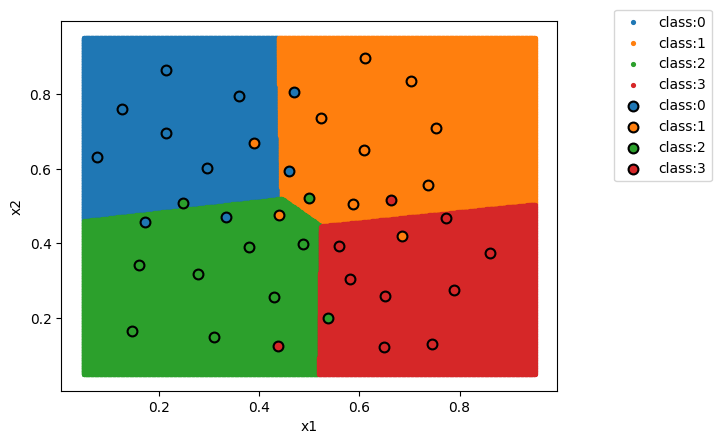

In [18]:
show_dataset_labels(x, y, ml_classifier_model, n_axis_pts=800)

In [35]:
# anyax = np.linspace(0.05, 0.95, num=120)
# xx = np.meshgrid(anyax, anyax)
# xx_vars = np.reshape(xx, (2, 120 ** 2))
# xx_vars_append = np.vstack([np.ones(xx_vars.shape[1]), xx_vars]).T
x_test = np.linspace(0.05, 0.95, num=120)
y_test_0 = -(x_test*weights[1,0]+weights[0,0])/weights[2,0]
y_test_1 = -(x_test*weights[1,1]+weights[0,1])/weights[2,0]
y_test_2 = -(x_test*weights[1,2]+weights[0,2])/weights[2,0]
y_test_3 = -(x_test*weights[1,3]+weights[0,3])/weights[2,0]

In [39]:
def lines_splitter(weight0, weight1):
    """
    weight0 = array([w00, w01, w02])
    weight1 = array([w10, w11, w12])
    """
    w0_normalized = weight0 / np.sqrt(weight0[1]**2+weight0[2]**2)
    w1_normalized = weight1 / np.sqrt(weight1[1]**2+weight1[2]**2)
    w_split1 = w0_normalized + w1_normalized
    w_split2 = w0_normalized - w1_normalized
    return w_split1, w_split2


In [41]:
splitter_group1 = lines_splitter(weights[:,0], weights[:,1])
splitter_group2 = lines_splitter(weights[:,1], weights[:,2])
splitter_group3 = lines_splitter(weights[:,2], weights[:,3])
splitter_group4 = lines_splitter(weights[:,3], weights[:,0])

In [43]:
y_splitter_01 = -(x_test*splitter_group1[0][1]+splitter_group1[0][0])/splitter_group1[0][2]
y_splitter_02 = -(x_test*splitter_group1[1][1]+splitter_group1[1][0])/splitter_group1[1][2]

y_splitter_11 = -(x_test*splitter_group2[0][1]+splitter_group2[0][0])/splitter_group2[0][2]
y_splitter_12 = -(x_test*splitter_group2[1][1]+splitter_group2[1][0])/splitter_group2[1][2]

y_splitter_21 = -(x_test*splitter_group3[0][1]+splitter_group3[0][0])/splitter_group3[0][2]
y_splitter_22 = -(x_test*splitter_group3[1][1]+splitter_group3[1][0])/splitter_group3[1][2]

y_splitter_31 = -(x_test*splitter_group4[0][1]+splitter_group4[0][0])/splitter_group4[0][2]
y_splitter_32 = -(x_test*splitter_group4[1][1]+splitter_group4[1][0])/splitter_group4[1][2]


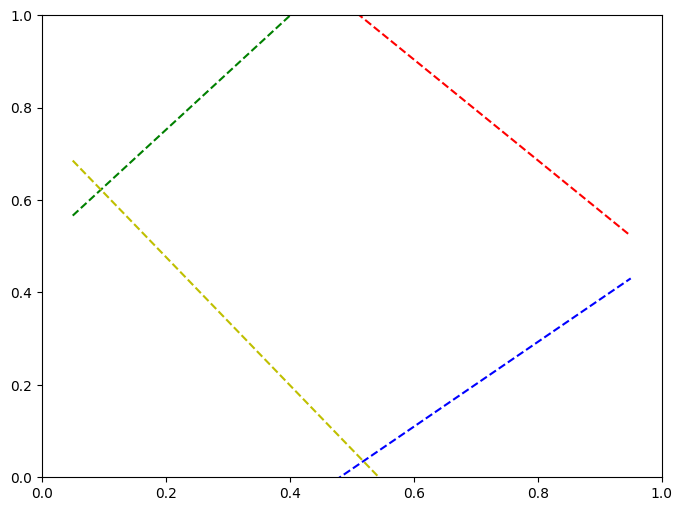

In [54]:
fig, ax = fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(x_test, y_test_0, "g--")
# ax.plot(x_test, y_splitter_01, "g-")
# ax.plot(x_test, y_splitter_01, "go-")

ax.plot(x_test, y_test_1, "r--")
# ax.plot(x_test, y_splitter_11, "r-")
# ax.plot(x_test, y_splitter_11, "ro-")

ax.plot(x_test, y_test_2, "b--")
# ax.plot(x_test, y_splitter_21, "b-")
# ax.plot(x_test, y_splitter_21, "bo-")

ax.plot(x_test, y_test_3, "y--")
# ax.plot(x_test, y_splitter_31, "y-")
# ax.plot(x_test, y_splitter_31, "yo-")

ax.set_xlim([0,1])
ax.set_ylim([0,1])
plt.show()

In [83]:
y

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.]])